Back to the main [Index](../index.ipynb)

# $G_0W_0$ band structure with star-function interpolation


Standard functionals (LDA and GGA), systematically underestimate band gaps, giving values
that are about 30-40% smaller than experimental data.
The inability of standard Kohn-Sham (KS) theory to give band gaps close to experiment is often referred to as the **band-gap problem**.

From a theoretical point of view this is not surprising since KS eigenvalues are not supposed to give the correct band energies.
The band structure of a crystal is rigorously defined as the energies needed to add or subtract electrons from the many-body system
which, in turn, are related to the difference between total energies of **many-body states** differing by one electron.

An alternative, more traditional, approach to the study of exchange-correlation effects in
many-body systems is provided by Many-Body Perturbation Theory (MBPT) which defines a rigorous approach to the description of excited-state properties, based on the Green's function formalism.

In this lesson, we discuss how to use the MBPT part of ABINIT to compute the band-structure of silicon
within the so-called $G_0W_0$ approximation.
For a very brief introduction to the many-body formalism, see MBPT_NOTES_.

.. _MBPT_NOTES: http://www.abinit.org/documentation/helpfiles/for-v7.10/tutorial/theory_mbt.html

### Related ABINIT variables

    * optdriver
    * ecuteps
    * ecutsigx
    * nband
    * gwcalctyp
    * gw_qprange
    * all gw** variables

## Description of the lesson

In this lesson, we will construct an `AbiPy` flow made of two works.
The first work is a standard KS band-structure calculation that consists of
an initial GS calculation to get the density followed by two NSCF calculations.

The first NSCF task computes the KS eigenvalues on a high-symmetry path in the BZ,
whereas the second NSCF task employs a homogeneous k-mesh so that one can compute
the DOS from the KS eigenvalues.
This work is similar to the one we have already encountered in lesson_dos_bands.

The second work represents the real GW workflow that uses the density computed in the first task of
the previous work  to compute the KS bands for many empty states.
The WFK file produced in this step is then used to compute the screened interaction $W$.
Finally, we perform a self-energy calculation that uses the $W$ produced
in the previous step and the WFK file to compute the matrix elements of the self-energy and
the $G_0W_0$ corrections for all the k-points in the IBZ and 8 bands (4 occupied + 4 empty)

Once the flow is completed, we can interpolate the $G_0W_0$ corrections.

Don't worry if there are steps of the entire procedure that are not clear to you.
$GW$ calculations are much more complicated than standard KS band structures and
the main goal of this lesson is to give you an overview of the Abipy capabilities.

Let's start with the usual import section:

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import seaborn
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
import abipy.flowtk as flowtk

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

and now we import the `make_inputs` function that generates the inputs files required by our `Flow`.

In [2]:
from lesson_g0w0 import make_inputs
abilab.print_source(make_inputs)

Ok the function is a little bit long but it's normal since we are running different kind of calculations,
each step has its own set of variables and $GW$ calculations are much more difficult than the KS ones.
If there are variables whose meaning is not clear to you, please take some time to read the Abinit documentation
and the standard $GW$ tutorials before proceeding.

For your convenience, we report the variables used to compute the screening and the electron self-energy

In [3]:
scf, bands_nscf, dos_nscf, gw_nscf, scr, sig = make_inputs(ngkpt=(2, 2, 2))

In [4]:
# Input for RPA screening calculation
scr

<AbinitInput at 4794861384>

In [5]:
# Input for G0W0 calculation with plasmon-pole model
sig

<AbinitInput at 4794861496>

Now we can use the 4 inputs file produced by `make_inputs` to generate our $GW$ flow.
The tricky part is represented by the connections among the tasks in the $GW$ part. 

In [6]:
from lesson_g0w0 import build_g0w0_flow
abilab.print_source(build_g0w0_flow)

Let's build the flow:

In [7]:
flow = build_g0w0_flow()

and visualize the connections with:

<IPython.core.display.Javascript object>


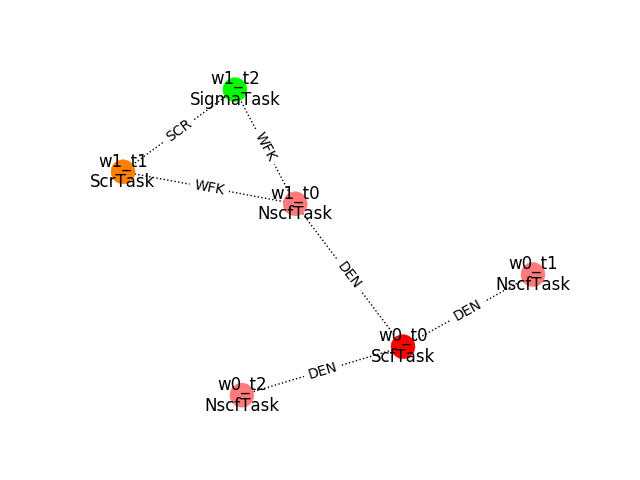

In [8]:
flow.plot_networkx(with_edge_labels=True);

As you can see, we have 2 works:

In [9]:
for i, work in enumerate(flow): 
    print("[%d] %s" % (i, work))

[0] <BandStructureWork, node_id=199316, workdir=flow_g0w0/w0>
[1] <Work, node_id=199320, workdir=flow_g0w0/w1>


In [10]:
bands_work = flow[0]
for task in bands_work: 
    print(task)

<ScfTask, node_id=199317, workdir=flow_g0w0/w0/t0>
<NscfTask, node_id=199318, workdir=flow_g0w0/w0/t1>
<NscfTask, node_id=199319, workdir=flow_g0w0/w0/t2>


In [11]:
!find flow_g0w0 -name "*_GSR.nc"

flow_g0w0/w0/t0/outdata/out_GSR.nc
flow_g0w0/w0/t1/outdata/out_GSR.nc
flow_g0w0/w0/t2/outdata/out_GSR.nc
flow_g0w0/w1/t0/outdata/out_GSR.nc


In [12]:
 with abilab.abiopen("flow_g0w0/w0/t1/outdata/out_GSR.nc") as gsr:
    ks_ebands_kpath = gsr.ebands
    
with abilab.abiopen("flow_g0w0/w0/t2/outdata/out_GSR.nc") as gsr:
    ks_ebands_kmesh = gsr.ebands

<IPython.core.display.Javascript object>


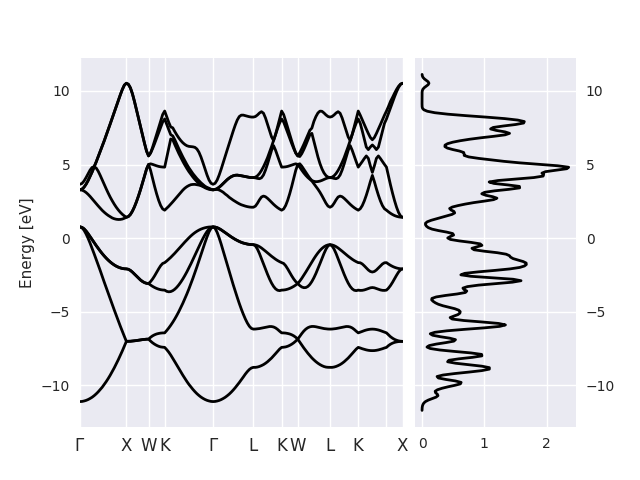

In [13]:
ks_edos = ks_ebands_kmesh.get_edos()
ks_ebands_kpath.plot_with_edos(ks_edos);

In [14]:
!find flow_g0w0 -name "*_SIGRES.nc"

flow_g0w0/w1/t2/outdata/out_SIGRES.nc


In [15]:
sigres = abilab.abiopen("flow_g0w0/w1/t2/outdata/out_SIGRES.nc") 
#print(sigres)

In [16]:
qpdata_gamma = sigres.get_dataframe_sk(spin=0, kpoint=(0, 0, 0))
qpdata_gamma.keys()

Index(['spin', 'kpoint', 'band', 'e0', 'qpe', 'qpe_diago', 'vxcme', 'sigxme',
       'sigcmee0', 'vUme', 'ze0', 'qpeme0', 'ecutwfn', 'ecuteps', 'ecutsigx',
       'scr_nband', 'sigma_nband', 'gwcalctyp', 'scissor_ene', 'nkibz'],
      dtype='object')

In [17]:
qpdata_gamma[['e0', 'qpe', 'qpe_diago', 'vxcme', 'sigxme', 'sigcmee0', 'ze0', 'qpeme0']]

,e0,qpe,qpe_diago,vxcme,sigxme,sigcmee0,ze0,qpeme0
0,-6.232452,(-5.69255281984-0.0112139492528j),-5.373871,-10.361555,-17.427556,(7.92458120188-0.0178331226667j),(0.628827012654+0j),(0.539899048941-0.0112139492528j)
1,5.632757,(6.26387492957-4.97649407714e-12j),6.431164,-11.160396,-13.117325,(2.75541868965-6.29624987028e-12j),(0.790390181405+0j),(0.631118084105-4.97649407714e-12j)
2,5.632757,(6.26380963263-4.97649407714e-12j),6.431246,-11.160313,-13.117325,(2.75541868965-6.29624987028e-12j),(0.790390181405+0j),(0.631052787091-4.97649407714e-12j)
3,5.632757,(6.26392593628-4.97649407714e-12j),6.431311,-11.160460,-13.117325,(2.75541868965-6.29624987028e-12j),(0.790390181405+0j),(0.631169090656-4.97649407714e-12j)
4,8.148321,(9.44413017905-9.42656628095e-06j),9.781334,-9.967322,-5.517241,(-2.81701278342-1.18800054783e-05j),(0.793481644275+0j),(1.29580897936-9.42656628095e-06j)
5,8.148321,(9.44408659867-9.42656628095e-06j),9.781370,-9.967267,-5.517241,(-2.81701278342-1.18800054783e-05j),(0.793481644275+0j),(1.29576539876-9.42656628095e-06j)
6,8.148321,(9.44411539726-9.42656628095e-06j),9.781389,-9.967304,-5.517241,(-2.81701278342-1.18800054783e-05j),(0.793481644275+0j),(1.2957941973-9.42656628095e-06j)
7,8.526280,(9.9798626859-5.32865515015e-05j),10.358426,-10.765880,-5.897033,(-3.03670087539-6.71642099301e-05j),(0.79337718045+0j),(1.45358237577-5.32865515015e-05j)


<IPython.core.display.Javascript object>


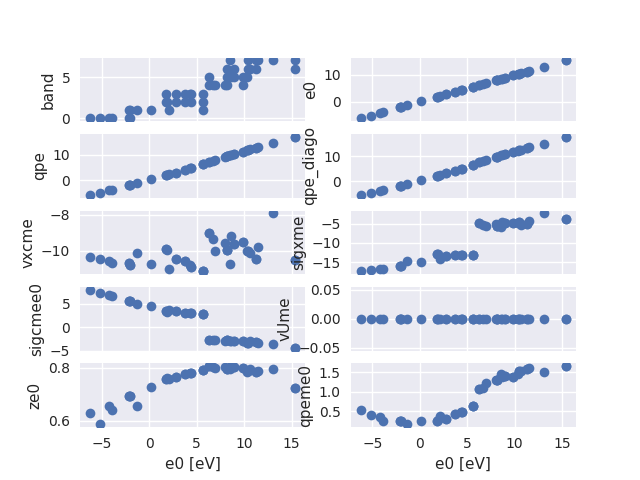

In [18]:
sigres.plot_qps_vs_e0();

In [19]:
r = sigres.interpolate(lpratio=5, ks_ebands_kpath=ks_ebands_kpath, ks_ebands_kmesh=None, ks_degatol=1e-4,
                       vertices_names=None, line_density=20, filter_params=None, only_corrections=False, verbose=0)

Will use: 30 star-functions. nstars/nk: 5.0
FIT vs input data: Mean Absolute Error= 2.75242791522e-13  [meV]


<IPython.core.display.Javascript object>


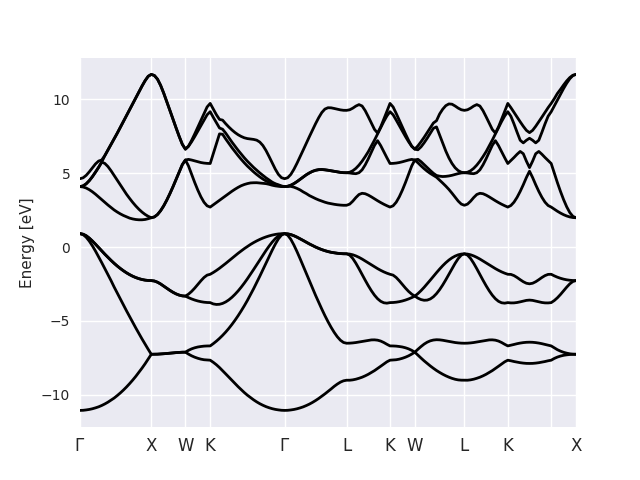

In [20]:
r.qp_ebands_kpath.plot();

In [21]:
# Use ElectronBandsPlotter to plot the KS and the QP band structure with matplotlib.
p = abilab.ElectronBandsPlotter()
p.add_ebands("LDA", ks_ebands_kpath, dos=None)
p.add_ebands("GW (interpolated)", r.qp_ebands_kpath, dos=None)

<IPython.core.display.Javascript object>


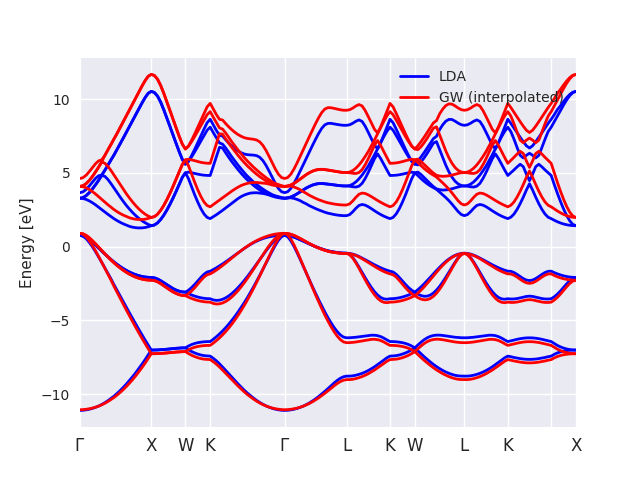

In [22]:
p.combiplot();

<IPython.core.display.Javascript object>


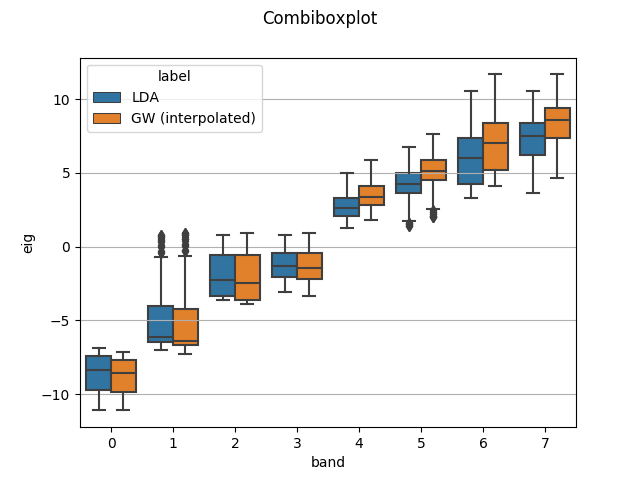

In [23]:
# By default, the two band energies are shifted wrt to *their* fermi level.
# Use e=0 if you don't want to shift the eigenvalus
# so that it's possible to visualize the QP corrections.

p.combiboxplot(title="Combiboxplot");

In [24]:
r2 = sigres.interpolate(lpratio=5, ks_ebands_kpath=ks_ebands_kpath, ks_ebands_kmesh=ks_ebands_kmesh, ks_degatol=1e-4,
                       vertices_names=None, line_density=20, filter_params=None, only_corrections=False, verbose=0)

qp_edos = r2.qp_ebands_kmesh.get_edos()

p2 = abilab.ElectronBandsPlotter()
p2.add_ebands("LDA", ks_ebands_kpath, dos=ks_edos)
p2.add_ebands("GW (interpolated)", r.qp_ebands_kpath, dos=qp_edos)

Will use: 30 star-functions. nstars/nk: 5.0
FIT vs input data: Mean Absolute Error= 2.75242791522e-13  [meV]


<IPython.core.display.Javascript object>


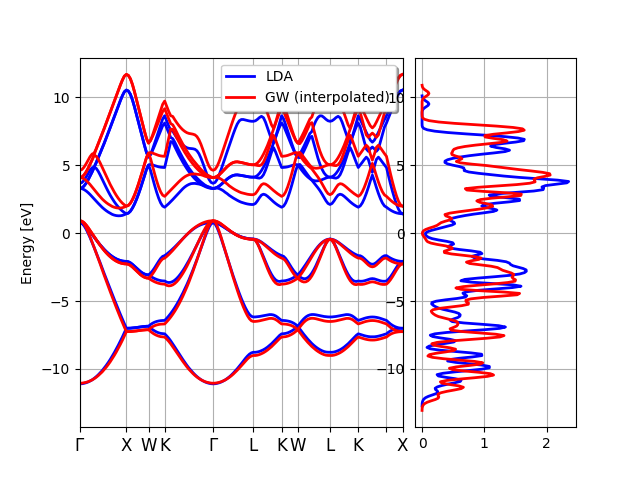

In [25]:
p2.combiplot();

# Analyzing the `Flow`

Call `lesson.analyze` to:
    
   * Interpolate the $GW$ corrections as a function of the initial KS energy
   * Apply the energy-dependent scissors operator to the initial KS bands in order 
     to compute an approximated GW band structure
   * Plot the approximated $GW$ band structure

Meaning of the figures:
    
   - Panels with the most important $GW$ results 
     (QP corrections, renornalization factor $Z$, matrix elements of the self-energy) 
   - QP corrections as a function of KS energies and interpolating function
   - Approximated $G_0W_0$ band structure obtained with the scissors operator 

Next
----

A logical next lesson would be lesson_bse.
Please consult the ipython notebook available on the abipy website